## Imports and Defines

In [108]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

In [109]:
teams = pd.read_csv('./src/teams.csv')
players = pd.read_csv('./src/players.csv')
matches = pd.read_csv('./src/matches.csv')

## Players Dataset

Посмотрим на данные в таблице Players

In [110]:
players.head(4)

,player_api_id,player_name,birthday,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,505942,Aaron Appindangoye,1992-02-29 00:00:00,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,505942,Aaron Appindangoye,1992-02-29 00:00:00,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,505942,Aaron Appindangoye,1992-02-29 00:00:00,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,505942,Aaron Appindangoye,1992-02-29 00:00:00,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [111]:
players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183978 entries, 0 to 183977
Data columns (total 42 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   player_api_id        183978 non-null  int64  
 1   player_name          183978 non-null  object 
 2   birthday             183978 non-null  object 
 3   date                 183978 non-null  object 
 4   overall_rating       183142 non-null  float64
 5   potential            183142 non-null  float64
 6   preferred_foot       183142 non-null  object 
 7   attacking_work_rate  177109 non-null  object 
 8   defensive_work_rate  183142 non-null  object 
 9   crossing             183142 non-null  float64
 10  finishing            183142 non-null  float64
 11  heading_accuracy     183142 non-null  float64
 12  short_passing        183142 non-null  float64
 13  volleys              181265 non-null  float64
 14  dribbling            183142 non-null  float64
 15  curve            

Приведем типы данных

In [112]:
players['date'] = players['date'].astype('datetime64[ns]')
players['birthday'] = players['birthday'].astype('datetime64[ns]')

Проверим на некорректные данные (< 0 и > 100)

In [113]:
players_score = players.select_dtypes(include='float64')
players_score_columns = players.select_dtypes(include='float64').columns
((players_score < 0).any().sum(), (players_score > 100).any().sum())

(0, 0)

*Все данные в допустимом диапазоне*

Оставим только самые последние данные по каждому игроку

In [114]:
players['rnk'] = players.groupby('player_api_id')['date'].rank(method='first', ascending=False)
players.query('rnk == 1', inplace=True)

Отделим goalkeepers от других игроков

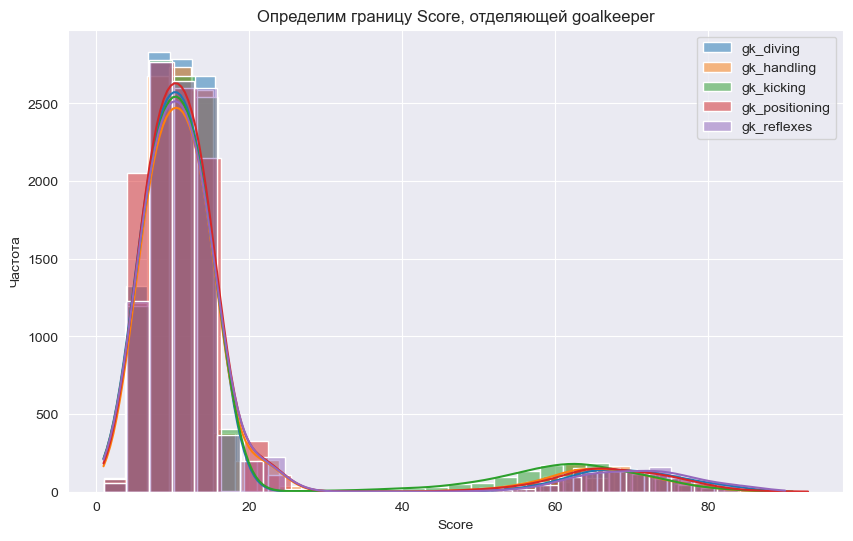

In [115]:
players_gk_columns = [col for col in players_score_columns if col.startswith('gk_')]
players_non_gk_columns = players_score_columns.difference(players_gk_columns)

plt.figure(figsize=(10, 6))

for column in players_gk_columns:
    sns.histplot(players[column], bins=30, kde=True, label=column)

plt.title('Определим границу Score, отделяющей goalkeeper')
plt.xlabel('Score')
plt.ylabel('Частота')
plt.legend()
plt.show()

In [116]:
gk_criteria = 40
players['is_gk'] = (players['gk_positioning'] > gk_criteria) & \
                   (players['gk_reflexes'] > gk_criteria) & \
                   (players['gk_diving'] > gk_criteria) & \
                   (players['gk_handling'] > gk_criteria)

Проверим параметры на пропущенные значения

In [117]:
missing_players_values = players.select_dtypes(include='float').isnull().sum()
missing_players_percentage = (missing_players_values / players.shape[0]) * 100
missing_players_percentage.sort_values(ascending=False)

jumping               4.321881
balance               4.321881
volleys               4.321881
agility               4.321881
curve                 4.321881
sliding_tackle        4.321881
vision                4.321881
penalties             0.000000
aggression            0.000000
interceptions         0.000000
positioning           0.000000
standing_tackle       0.000000
marking               0.000000
strength              0.000000
gk_diving             0.000000
gk_handling           0.000000
gk_kicking            0.000000
gk_positioning        0.000000
gk_reflexes           0.000000
long_shots            0.000000
overall_rating        0.000000
stamina               0.000000
potential             0.000000
shot_power            0.000000
reactions             0.000000
sprint_speed          0.000000
acceleration          0.000000
ball_control          0.000000
long_passing          0.000000
free_kick_accuracy    0.000000
dribbling             0.000000
short_passing         0.000000
heading_

*Пропусков менее 5%*

 Заполним пропуски средним значением.

In [118]:
players_columns_to_fill = missing_players_percentage[missing_players_percentage > 0].index
mean_players_values = players[players_columns_to_fill].mean()
players[players_columns_to_fill] = players[missing_players_percentage[missing_players_percentage > 0].index].fillna(
    mean_players_values)

Вычислим средний Score каждого игрока

In [119]:
def calculate_player_score(row):
    if row['is_gk']:
        return row[players_gk_columns].mean()
    return row[players_non_gk_columns].mean()


players['player_score'] = players.apply(calculate_player_score, axis=1)

Установим player_api_id как Index и оставим только нужные колонки. Так как используемая нами методология расчета player_score проще, чем предлагаемая в данных. То оставим обе. Для улучшения нашего метода можно: разделить на защитников/нападающих/полузащитников, также использовать категориальные переменные.

In [120]:
players.set_index('player_api_id', inplace=True)
players = players[['player_name', 'overall_rating','player_score']]

players.head(2)

,player_name,overall_rating,player_score
player_api_id,,,
505942,Aaron Appindangoye,67.0,57.3
155782,Aaron Cresswell,74.0,69.9


## Teams Dataset

Посмотрим на данные в Teams Dataset

In [122]:
teams.head(4)

,team_api_id,team_long_name,team_short_name,defenceTeamWidthClass,defenceTeamWidth,defencePressureClass,defencePressure,defenceDefenderLineClass,defenceAggressionClass,defenceAggression,...,chanceCreationPassing,chanceCreationCrossingClass,chanceCreationCrossing,buildUpPlaySpeedClass,buildUpPlaySpeed,buildUpPlayPositioningClass,buildUpPlayPassingClass,buildUpPlayPassing,buildUpPlayDribblingClass,buildUpPlayDribbling
0,9930,FC Aarau,AAR,Normal,45,Medium,50,Cover,Press,55,...,60,Normal,65,Balanced,60,Organised,Mixed,50,Little,NaN
1,9930,FC Aarau,AAR,Normal,54,Medium,47,Cover,Press,44,...,54,Normal,63,Balanced,52,Organised,Mixed,56,Normal,48.0
2,9930,FC Aarau,AAR,Normal,54,Medium,47,Cover,Press,44,...,54,Normal,63,Balanced,47,Organised,Mixed,54,Normal,41.0
3,8485,Aberdeen,ABE,Wide,70,Medium,60,Cover,Double,70,...,70,Lots,70,Fast,70,Organised,Long,70,Little,NaN


In [123]:
teams.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   team_api_id                     1458 non-null   int64  
 1   team_long_name                  1458 non-null   object 
 2   team_short_name                 1458 non-null   object 
 3   defenceTeamWidthClass           1458 non-null   object 
 4   defenceTeamWidth                1458 non-null   int64  
 5   defencePressureClass            1458 non-null   object 
 6   defencePressure                 1458 non-null   int64  
 7   defenceDefenderLineClass        1458 non-null   object 
 8   defenceAggressionClass          1458 non-null   object 
 9   defenceAggression               1458 non-null   int64  
 10  date                            1458 non-null   object 
 11  chanceCreationShootingClass     1458 non-null   object 
 12  chanceCreationShooting          14

In [124]:
teams['date'] = teams['date'].astype('datetime64[ns]')

In [125]:
missing_teams_values = teams.isnull().sum()
missing_teams_percentage = (missing_teams_values / teams.shape[0]) * 100
missing_teams_percentage.sort_values(ascending=False)

buildUpPlayDribbling              66.460905
chanceCreationPositioningClass     0.000000
buildUpPlayDribblingClass          0.000000
buildUpPlayPassing                 0.000000
buildUpPlayPassingClass            0.000000
buildUpPlayPositioningClass        0.000000
buildUpPlaySpeed                   0.000000
buildUpPlaySpeedClass              0.000000
chanceCreationCrossing             0.000000
chanceCreationCrossingClass        0.000000
chanceCreationPassing              0.000000
chanceCreationPassingClass         0.000000
team_api_id                        0.000000
team_long_name                     0.000000
chanceCreationShootingClass        0.000000
date                               0.000000
defenceAggression                  0.000000
defenceAggressionClass             0.000000
defenceDefenderLineClass           0.000000
defencePressure                    0.000000
defencePressureClass               0.000000
defenceTeamWidth                   0.000000
defenceTeamWidthClass           

Удалим атрибуты, содержащие > 60% пропусков. Остальные атрибуты пропусков не имеют.

In [126]:
teams_columns_to_drop = missing_teams_percentage[missing_teams_percentage > 60].index
teams.drop(columns=teams_columns_to_drop, inplace=True)

## Matches Dataset

In [127]:
missing_matches_values = matches.isnull().sum()
missing_matches_percentage = (missing_matches_values / matches.shape[0]) * 100
missing_matches_percentage.sort_values(ascending=False)

PSH            57.011432
PSD            57.011432
PSA            57.011432
BSA            45.490589
BSD            45.490589
                 ...    
date            0.000000
stage           0.000000
season          0.000000
league_id       0.000000
league_name     0.000000
Length: 117, dtype: float64

Имеем очень много пропусков в атрибутах. Удалим атрибуты с более, чем 30% пропусков.

In [128]:
matches_columns_to_drop = missing_matches_percentage[missing_matches_percentage > 30].index
matches.drop(columns=matches_columns_to_drop, inplace=True)